In [1]:
import torch
from PIL import Image
import torchvision.transforms as T

In [2]:
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

Using cache found in /home/roger/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [3]:
img = Image.open('meta_dog.png')

transform = T.Compose([
    T.Resize(448),
    T.CenterCrop(448),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

img = transform(img)[:3].unsqueeze(0)

In [4]:
with torch.no_grad():
    features = dinov2_vitg14.forward_features(img)["x_norm_patchtokens"][0]
    print(features.shape)

torch.Size([1024, 384])


In [5]:
features.shape

torch.Size([1024, 384])

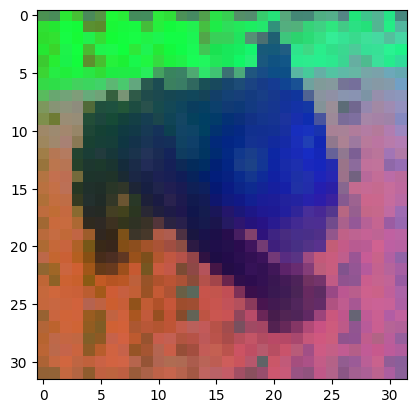

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(features)

pca_features = pca.transform(features)
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
pca_features = pca_features * 255

plt.imshow(pca_features.reshape(32, 32, 3).astype(np.uint8))